In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.ghostnetv3 import GhostNetV3
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/ghostnetv3")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
DEVICE = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

7


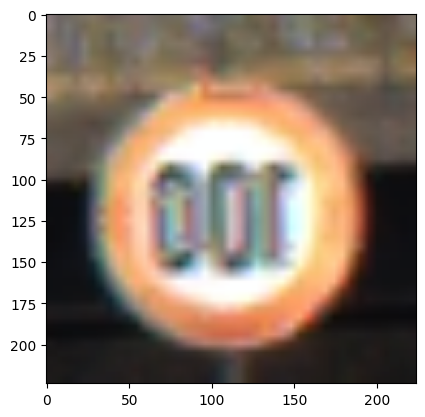

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = GhostNetV3(output_size=num_class).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                                      Param #
GhostNetV3                                                                  --
├─Conv2dNormActivation: 1-1                                                 --
│    └─Conv2d: 2-1                                                          432
│    └─BatchNorm2d: 2-2                                                     32
│    └─ReLU: 2-3                                                            --
├─Sequential: 1-2                                                           --
│    └─GhostLayerV3: 2-4                                                    --
│    │    └─ResBlock: 3-1                                                   1,584
│    └─GhostLayerV3: 2-5                                                    --
│    │    └─ResBlock: 3-2                                                   4,664
│    └─GhostLayerV3: 2-6                                                    --
│    │    └─ResBlock: 3-3               

# training

In [32]:
epochs = 10
acc_iters = 256 / BATCH_SIZE

In [ ]:
trainer = ClassificationTrainer(epochs, DEVICE, acc_iters)
trainer.recorder.increment_data_size(len(train_dataset))

In [34]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [35]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [37]:
scaler = torch.cuda.amp.GradScaler()

In [38]:
training_loss = trainer.run(train_loader, model, optim, criterion, scheduler=scheduler, scaler=scaler)

Enable AMP: True
Training...


  0%|          | 0/832 [00:00<?, ?it/s]

100%|██████████| 832/832 [13:31<00:00,  1.03it/s]


------------------------------------
Epoch 1
------------------------------------
0.008922632512365193 (0%)


100%|██████████| 832/832 [03:15<00:00,  4.25it/s]


------------------------------------
Epoch 2
------------------------------------
0.0019366647230808051 (-78%)


100%|██████████| 832/832 [03:18<00:00,  4.19it/s]


------------------------------------
Epoch 3
------------------------------------
0.0006208373350091276 (-68%)


100%|██████████| 832/832 [03:15<00:00,  4.26it/s]


------------------------------------
Epoch 4
------------------------------------
0.0003485426193455587 (-44%)


100%|██████████| 832/832 [03:14<00:00,  4.27it/s]


------------------------------------
Epoch 5
------------------------------------
0.0002332932322059529 (-33%)


100%|██████████| 832/832 [03:15<00:00,  4.25it/s]


------------------------------------
Epoch 6
------------------------------------
0.00019377000429234047 (-17%)


100%|██████████| 832/832 [03:14<00:00,  4.28it/s]


------------------------------------
Epoch 7
------------------------------------
0.00013002739380555677 (-33%)


100%|██████████| 832/832 [03:38<00:00,  3.81it/s]


------------------------------------
Epoch 8
------------------------------------
0.00014227427627510936 (9%)


100%|██████████| 832/832 [03:45<00:00,  3.68it/s]


------------------------------------
Epoch 9
------------------------------------
0.00010294457747217814 (-28%)


100%|██████████| 832/832 [03:59<00:00,  3.47it/s]

------------------------------------
Epoch 10
------------------------------------
0.00016828984993666536 (63%)


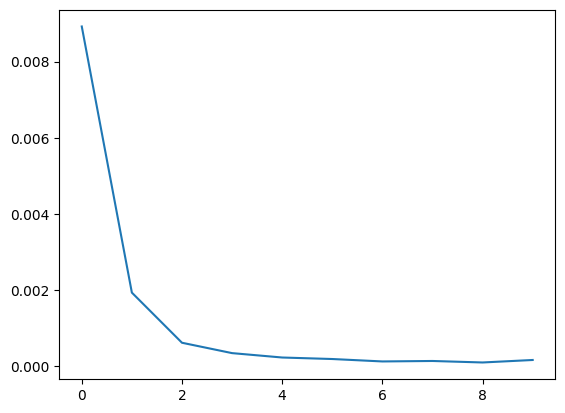

In [39]:
plt.plot(training_loss)

In [13]:
model_path = artifact_path / f'ghostnetv3.train.pth'

In [41]:
torch.save(model.state_dict(), model_path)

In [14]:
get_file_size(model_path)

'20.68MiB'

In [15]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

In [16]:
from torchlake.image_classification.models.ghostnetv2 import GhostNetV2

In [17]:
infer_model = GhostNetV2(output_size=num_class).to(DEVICE)

In [18]:
model.reparameterize(infer_model)

In [19]:
model_path = artifact_path / f'ghostnetv3.infer.pth'

In [20]:
torch.save(infer_model.state_dict(), model_path)

In [21]:
get_file_size(model_path)

'20.02MiB'

In [22]:
infer_model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# inference

In [23]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [24]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [25]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [26]:
evaluator = ClassificationEvaluator(num_class, DEVICE)

In [ ]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [03:21<00:00,  1.96it/s]

[[ 48   8   0 ...   0   0   0]
 [  0 711   3 ...   0   0   0]
 [  0  11 736 ...   0   0   0]
 ...
 [  0   0   0 ...  77   0   0]
 [  0   0   0 ...   0  60   0]
 [  0   0   0 ...   1   6  74]]


In [22]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.8
1         : 0.9875
2         : 0.9813333333333333
3         : 0.9644444444444444
4         : 0.946969696969697
5         : 0.9603174603174603
6         : 0.8466666666666667
7         : 0.9222222222222223
8         : 0.9777777777777777
9         : 0.9979166666666667
10        : 0.9893939393939394
11        : 0.9952380952380953
12        : 0.9507246376811594
13        : 0.9888888888888889
14        : 0.9925925925925926
15        : 0.9857142857142858
16        : 0.9933333333333333
17        : 0.9472222222222222
18        : 0.7794871794871795
19        : 0.11666666666666667
20        : 0.6222222222222222
21        : 0.43333333333333335
22        : 0.9083333333333333
23        : 0.9666666666666667
24        : 0.9444444444444444
25        : 0.95625
26        : 0.8222222222222222
27        : 0.48333333333333334
28        : 0.9066666666666666
29        : 0.9888888888888889
30        : 0.14
31        : 0.9296296296296296
32        : 0.9833333333333333
33        : 0.6666666666666

In [23]:
per_class_acc.mean()

0.8459682117680096

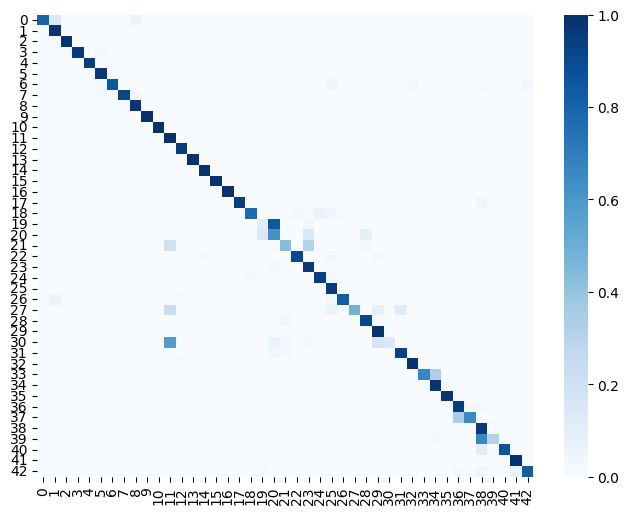

In [24]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [27]:
evaluator = ClassificationEvaluator(num_class, DEVICE)

In [28]:
confusion_matrix = evaluator.run(test_loader, infer_model)

100%|██████████| 395/395 [02:43<00:00,  2.42it/s]

[[ 48   8   0 ...   0   0   0]
 [  0 711   3 ...   0   0   0]
 [  0  11 736 ...   0   0   0]
 ...
 [  0   0   0 ...  77   0   0]
 [  0   0   0 ...   0  60   0]
 [  0   0   0 ...   1   6  74]]


In [29]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.8
1         : 0.9875
2         : 0.9813333333333333
3         : 0.9644444444444444
4         : 0.946969696969697
5         : 0.9603174603174603
6         : 0.8466666666666667
7         : 0.9222222222222223
8         : 0.9777777777777777
9         : 0.9979166666666667
10        : 0.9893939393939394
11        : 0.9952380952380953
12        : 0.9507246376811594
13        : 0.9888888888888889
14        : 0.9925925925925926
15        : 0.9857142857142858
16        : 0.9933333333333333
17        : 0.9472222222222222
18        : 0.7794871794871795
19        : 0.11666666666666667
20        : 0.6222222222222222
21        : 0.43333333333333335
22        : 0.9083333333333333
23        : 0.9666666666666667
24        : 0.9444444444444444
25        : 0.95625
26        : 0.8222222222222222
27        : 0.48333333333333334
28        : 0.9066666666666666
29        : 0.9888888888888889
30        : 0.14
31        : 0.9296296296296296
32        : 0.9833333333333333
33        : 0.6666666666666

In [30]:
per_class_acc.mean()

0.8459682117680096

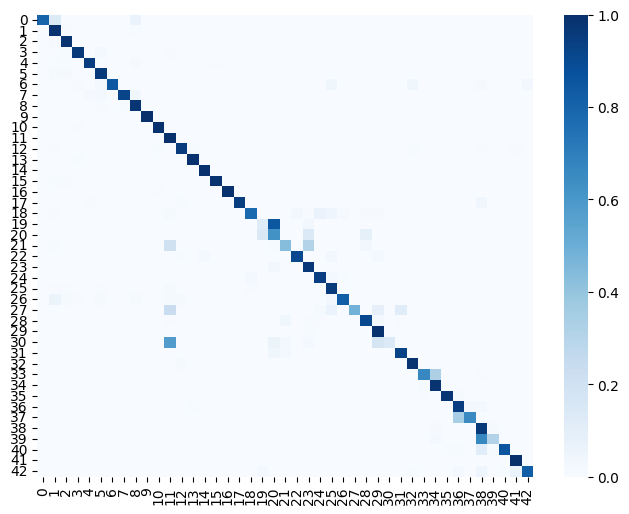

In [31]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)